# Automated Detection of Claims in TikTok Videos

## Project Overview

This project aims to develop a predictive model that classifies whether TikTok videos contain user claims or opinions. The goal is to help TikTok's moderation team streamline the process of reviewing content that has been flagged by prioritizing user reports more effectively. Using a dataset of TikTok content, machine learning models were trained, evaluated and tested on their ability to accurately classify content as either claim or opinion-based.


## Business Problem

TikTok relies on user reports to identify potentially problematic content (misinformation, claims, inappropriate material, etc...). With millions of users creating a vast amount of data everyday, Tiktok has a significant challenge in processing all of the reports made.

The content moderation team needs to assess whether flagged content contains factual claims or simply expresses opinions. Classifying content into these two categories can help TikTok reduce the workload on moderators, allowing them to prioritize claim-based content that may require quicker and/or more thorough reviews.This will not only reduce response time but also improve the user experience by handling harmful or misleading content more efficiently.


## Data

The dataset collected includes several variables that can help identify claim/oppinion based content:

* Video id: Identifying number assigned to video upon publication on TikTok
* Video duration: How long the published video is in seconds
* Video transcription text: Transcribed text of the words spoken in the video
* Verified status: Whether the TikTok user who published the video is either “verified” or “not verified”
* Author ban status: Whether the TikTok user who published the video is either “active”, “under scrutiny” or “banned”
* Video view count: The total number of views a video has
* Video like count: The total number of likes a video has
* Video share count: The total number of times a video has been shared
* Video download count: The total number of times a video has been downloaded
* Video comment count: The total number of comments a video has
* Claim status (Target): Whether the video has a "claim" or an "opinion".

## Modelling

In [62]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Data modeling
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Data evaluation
import sklearn.metrics as metrics
from xgboost import plot_importance

In [41]:
data = pd.read_csv("tiktok_dataset.csv")

### EDA

In [42]:
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [43]:
data.shape

(19382, 12)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [45]:
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


#### Checking for missing values

In [46]:
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

There are at least 298 rows with missing data

In [47]:
data[data.isna().any(axis=1)].head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
19084,19085,NaN,4380513697,39,NaN,not verified,active,NaN,NaN,NaN,NaN,NaN
19085,19086,NaN,8352130892,60,NaN,not verified,active,NaN,NaN,NaN,NaN,NaN
19086,19087,NaN,4443076562,25,NaN,not verified,active,NaN,NaN,NaN,NaN,NaN
19087,19088,NaN,8328300333,7,NaN,not verified,active,NaN,NaN,NaN,NaN,NaN
19088,19089,NaN,3968729520,8,NaN,not verified,active,NaN,NaN,NaN,NaN,NaN


It appears that all observations with missing data only have information on the video's id, duration and author.

Observtions are missing the most important information and as such should be removed

In [48]:
data.dropna(inplace=True)

#### Checking for duplicates

In [49]:
data.duplicated().sum()

0

There isn't any duplicated data

#### Deleting purposeless information

In [50]:
data.drop(columns=['#','video_id'],inplace=True)

#### Checking for outliers

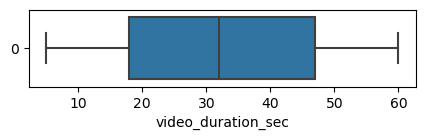

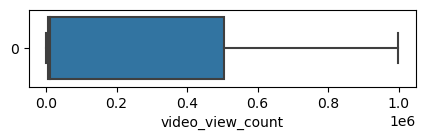

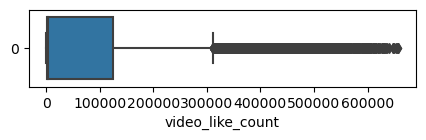

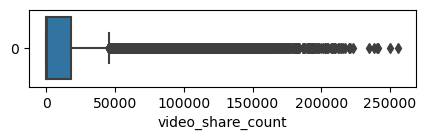

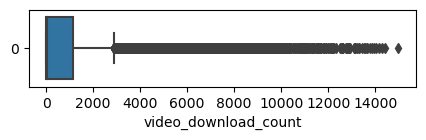

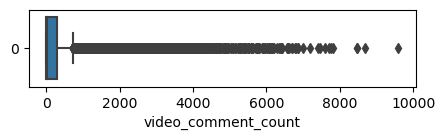

In [51]:
for column in data.select_dtypes(include=['int64','float64']).columns:
    plt.figure(figsize=(5,1))
    sns.boxplot(data[column],orient='h')
    plt.xlabel(column)
    plt.show()

Video like, share comment and download counts are significantly right-skewed, with most videos having low popularity scores while the rare few that go viral increase tremendously

Checking predictor feature class balance

In [52]:
data.claim_status.value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

#### Feature transformation

In [57]:
data.claim_status.unique()

array(['claim', 'opinion'], dtype=object)

In [58]:
data.verified_status.unique()

array(['not verified', 'verified'], dtype=object)

In [59]:
data.author_ban_status.unique()

array(['under review', 'active', 'banned'], dtype=object)

The three categorical features to handle are claim_status, verified_status, and author_ban_status:

Two of them are binary
* claim_status: opinion , claim
* verified_status: not verified , verified

While the last is ordinal in nature
* author_ban_status: banned , under review , active

In [60]:
# One-hot encoding the binary categorical features
data.claim_status = data.claim_status.replace({'opinion': 0, 'claim': 1})
data.verified_status = data.verified_status.replace({'not verified': 0, 'verified': 1})

# Label encoding the ordinal feature
data.author_ban_status = data.author_ban_status.replace({'banned':0,'under review': 1, 'active': 2})

In [61]:
data.head()

,claim_status,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_len
0,1,59,someone shared with me that drone deliveries a...,0,1,343296.0,19425.0,241.0,1.0,0.0,97
1,1,32,someone shared with me that there are more mic...,0,2,140877.0,77355.0,19034.0,1161.0,684.0,107
2,1,31,someone shared with me that american industria...,0,2,902185.0,97690.0,2858.0,833.0,329.0,137
3,1,25,someone shared with me that the metro of st. p...,0,2,437506.0,239954.0,34812.0,1234.0,584.0,131
4,1,19,someone shared with me that the number of busi...,0,2,56167.0,34987.0,4110.0,547.0,152.0,128


#### Feature extraction

In [53]:
data['text_len']=data.video_transcription_text.apply(len)

Text length of videos with claims versus opinions

In [54]:
data[['claim_status','text_len']].groupby(['claim_status']).mean().reset_index()

,claim_status,text_len
0,claim,95.376978
1,opinion,82.722562


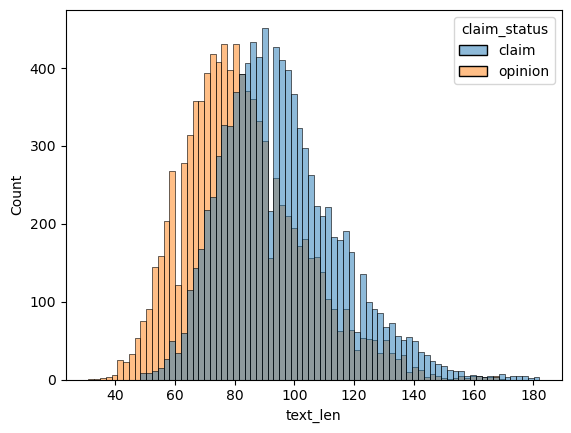

In [55]:
sns.histplot(x=data.text_len,hue=data.claim_status)
plt.show()

Tokenizing the text column

In [63]:
# Tokenizing text into 2-grams
c_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
c_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [65]:
# Fitting vectorizer into the data
count_data = c_vec.fit_transform(data['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [74]:
# Creating the dataframe counting the 15 most used n-grams
count_df = pd.DataFrame(data=count_data, columns=c_vec.get_feature_names_out())

count_df

,colleague discovered,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,learned news,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19079,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19080,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19082,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
# Updating the original datarame
data = pd.concat([data.drop(columns='video_transcription_text'),count_df],axis=1)

data.head()

,claim_status,video_duration_sec,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_len,...,friend read,internet forum,learned media,learned news,media claim,news claim,point view,read media,social media,willing wager
0,1,59,0,1,343296.0,19425.0,241.0,1.0,0.0,97,...,0,0,0,0,0,0,0,0,0,0
1,1,32,0,2,140877.0,77355.0,19034.0,1161.0,684.0,107,...,0,0,0,0,0,0,0,0,0,0
2,1,31,0,2,902185.0,97690.0,2858.0,833.0,329.0,137,...,0,0,0,0,0,0,0,0,0,0
3,1,25,0,2,437506.0,239954.0,34812.0,1234.0,584.0,131,...,0,0,0,0,0,0,0,0,0,0
4,1,19,0,2,56167.0,34987.0,4110.0,547.0,152.0,128,...,0,0,0,0,0,0,0,0,0,0


## Creating the ML models

In [77]:
x=data.drop(columns='claim_status')
y=data.claim_status

In [78]:
#Creating 3 different subsets with the following percentages train-0.6 , validate-0.2 , test-0.2

x_tr,x_test,y_tr,y_test = train_test_split(x,y,random_state=0,test_size=0.2)
x_train,x_val,y_train,y_val=train_test_split(x_tr,y_tr,random_state=0,test_size=0.25)

In [79]:
# Making sure all dataframes are as expected
for type in ['train','test','val']:
    print('x'+type+':',globals()['x_'+type].shape)
    print('y'+type+':',globals()['y_'+type].shape)

xtrain: (11450, 24)
ytrain: (11450,)
xtest: (3817, 24)
ytest: (3817,)
xval: (3817, 24)
yval: (3817,)


### Random Forest

The evaluation metric chosen is recall as it most emphasizes a reduction in False Negatives. The Tiktok team wants to be as sure as possible that videos flagged by the model are indeed claims or not

In [80]:
# Instantiating the random forest model
rf=RandomForestClassifier(random_state=0)

# Selecting hyperparameters to tune
cv_params = {
    'max_depth': [5, 7, None],
    'max_features': [0.3, 0.6],
    'max_samples': [0.7],
    'min_samples_leaf': [1,2],
    'min_samples_split': [2,3],
    'n_estimators': [75,100,200],
}

# Selecting scores
scoring=('precision','accuracy','recall','f1')

# Instantiating the Cross-Validation classifier
clf=GridSearchCV(rf,param_grid=cv_params,scoring=scoring,cv=5,refit='recall')

In [81]:
%%time
clf.fit(x_train,y_train)

CPU times: total: 9min 28s
Wall time: 9min 49s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=('precision', 'accuracy', 'recall', 'f1'))

In [84]:
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': None, 'max_features': 0.6, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}
0.9948228253467271


### Gradient Boosting

In [86]:
xgb = XGBClassifier( objective = 'binary:logistic' , random_state = 0 )

xgb_params ={'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

clf_xgb = GridSearchCV(xgb,param_grid=xgb_params,scoring=scoring,cv=5,refit='recall')

In [89]:
%%time
clf_xgb.fit(x_train, y_train)

CPU times: total: 2min 6s
Wall time: 39.6 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=('precision', 'accuracy', 'recall', 'f1'))

In [90]:
print(clf_xgb.best_params_)
print(clf_xgb.best_score_)

{'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 300}
0.989645054622456


### Evaluating the models

Random Forest:

In [91]:
y_rf_pred=clf.best_estimator_.predict(x_val)

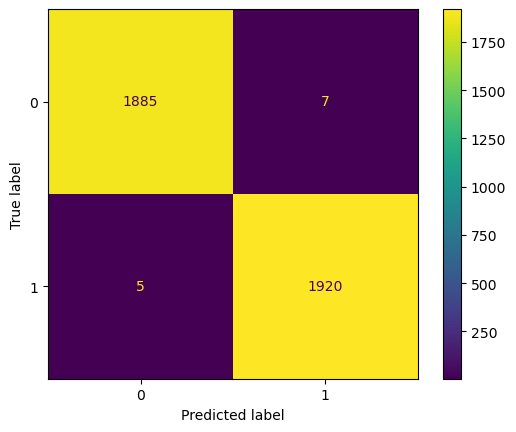

In [93]:
# Calculating the confusion matrix for the Random Forest
cm_rf = metrics.confusion_matrix(y_val,y_rf_pred)

# Display of confusion matrix
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_rf).plot()

In [94]:
target_labels = ['opinion', 'claim']
print(metrics.classification_report(y_val, y_rf_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



XGBoost:

In [95]:
y_xgb_pred=clf_xgb.best_estimator_.predict(x_val)

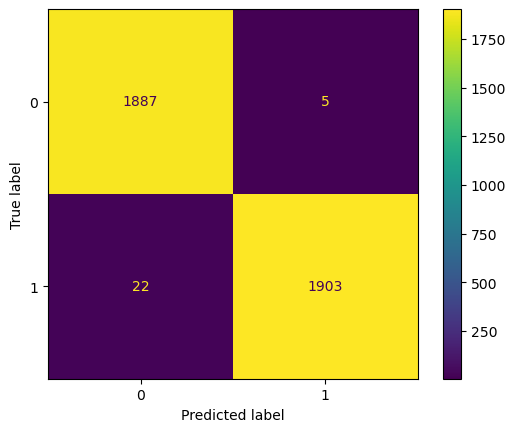

In [96]:
# Calculating the confusion matrix for the Random Forest
cm_xgb = metrics.confusion_matrix(y_val,y_xgb_pred)

# Display of confusion matrix
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_xgb).plot()

In [97]:
print(metrics.classification_report(y_val, y_xgb_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



Both models are able to obtain near perfect results, but the Random Forest manages to eek out a victory with a marginally higher recall evaluation score

### Testing

Using the best model to test never-seen-before data as a predictor for future behaviour

In [101]:
y_pred = clf.best_estimator_.predict(x_test)

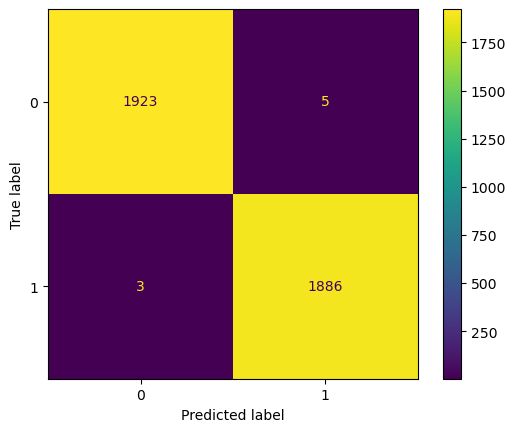

In [102]:
# Calculating the confusion matrix for the Random Forest
cm_rf = metrics.confusion_matrix(y_test,y_pred)

# Display of confusion matrix
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_rf).plot()

#### Feature importances of the best model

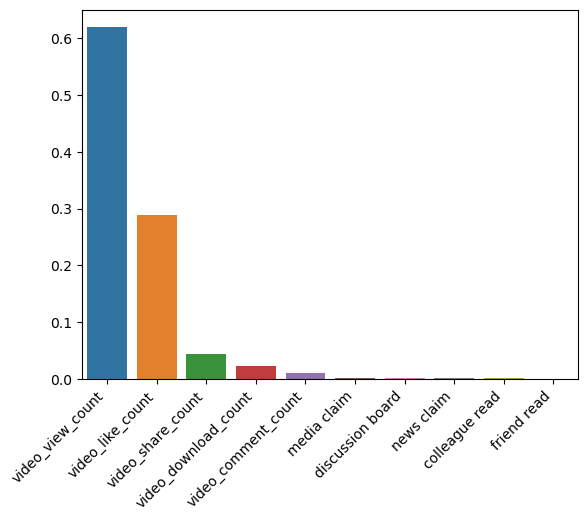

In [119]:
importances = clf.best_estimator_.feature_importances_

rf_importances = pd.Series(importances, index=x_test.columns).sort_values(ascending=False)[:10]

sns.barplot(x=rf_importances.index,y=rf_importances)
plt.xticks(rotation=45,ha='right')
plt.show()

The most predictive features are all related to the popularity of video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.

## Conclusion

The models successfully demonstrate the potential of machine learning to automate the detection of video claims in TikTok, with the best-performing model, a Random Forest, providing near-perfect classification of claims.

## Recommendations:

* **Implement the predictive model**: The model can be integrated into the moderation pipeline to automatically flag claim-based content for faster reviews.

* **Combine predictive models with human moderators**: While the model performs well, the automated system should still be complemented by human reviewers, especially for more situational cases.

## Future Steps

* Expand the dataset to include multiple languages so it can work across the entirety of the content.

* Continue to improve the model with the feedback from moderators to include more subjective cases and improve performance over time.